In [1]:
import os 
import json 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(pd.__version__)

1.0.5


# Part 1 - Exploratory data analysis
### Objectives
Aggregate login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [3]:
with open('logins.json') as f:
    data = json.load(f)
#     print(data.keys())
#     print(data)
    f.close()

In [4]:
# load data into dataframe
login_df = pd.read_json('logins.json').sort_values(by='login_time')
login_df.head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [5]:
print(login_df.iloc[0].dtype)

datetime64[ns]


In [6]:
import datetime as dt

login_df['date'] = login_df.login_time.dt.date
print(login_df.head())
# acquire count of logins in 15 minute intervals 
count_df = login_df.groupby([login_df.login_time.dt.floor('15Min')]).size()
count_df = count_df.reset_index()
# count_df = count_df.set_index('login_time')
count_df.columns = ['login_time','15min_count']


count_df.head()

           login_time        date
6 1970-01-01 20:12:16  1970-01-01
0 1970-01-01 20:13:18  1970-01-01
1 1970-01-01 20:16:10  1970-01-01
3 1970-01-01 20:16:36  1970-01-01
2 1970-01-01 20:16:37  1970-01-01


,login_time,15min_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [7]:
# group daily count by date 
daily_count = login_df.groupby(['date',login_df.login_time.dt.floor('15Min')]).size()
# reset index 
daily_count = daily_count.reset_index()
# rename columns
daily_count.columns = ['date','login_time','login_count']
# extract time
daily_count['time'] = daily_count.login_time.apply(lambda x: dt.datetime.strftime(x,'%H:%M'))
# reorder by time 
daily_count = daily_count.sort_values(by='time')


daily_count.head()

,date,login_time,login_count,time
296,1970-01-05,1970-01-05,8,00:00
5414,1970-03-02,1970-03-02,5,00:00
4127,1970-02-16,1970-02-16,9,00:00
8663,1970-04-06,1970-04-06,6,00:00
1487,1970-01-18,1970-01-18,14,00:00


In [8]:
daily_count.describe()

,login_count
count,9381.000000
mean,9.928792
std,8.263146
min,1.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,73.000000


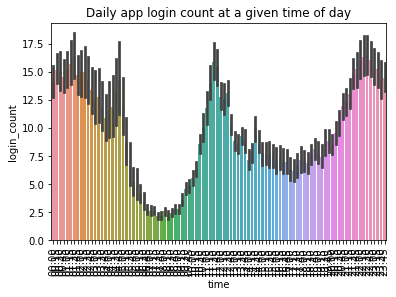

In [9]:
sns.barplot(x='time',y='login_count',data=daily_count)
plt.rcParams["figure.figsize"] = (21,3)
plt.title('Daily app login count at a given time of day')
plt.xticks(rotation=90)
plt.show()

In [10]:
print('Most logins date and time:',daily_count.loc[daily_count['login_count'].idxmax()])
print('Least logins date and time:',daily_count.loc[daily_count['login_count'].idxmin()])
print('Day with Highest average daily login on {}: {}'.format((daily_count.groupby('date')['login_count'].mean().idxmax()),round(daily_count.groupby('date')['login_count'].mean().max(),2)))
# print('Day with lowest average daily login:',daily_count.groupby('date')['login_count'].mean().min())

Most logins date and time: date                    1970-03-01
login_time     1970-03-01 04:30:00
login_count                     73
time                         04:30
Name: 5337, dtype: object
Least logins date and time: date                    1970-03-09
login_time     1970-03-09 01:45:00
login_count                      1
time                         01:45
Name: 6057, dtype: object
Day with Highest average daily login on 1970-04-04: 19.68


#### Observations
The graph shown above tracks the average login activity throughout the day, we can see that the app gets the most number of logins at night with sustained login activity between 9pm to 5am. The maximum number of logins recorded was 73 on March 1st at 4:30 am. During work hours between 5:30am to 10am, the activity drops by roughly 33\%, averaging around 1-3 logins. Your app averages 8 logins every 15 minutes between 1pm to 8pm.

###### About Data quality:
It looks like the timestamps were not formatted correctly during the ingestion phase as the timestamps are from start of unix time, which doesn't seem right. 

# Part 2 - Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. 
The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

#### Objectives:
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

In [11]:
challenge_df = pd.read_json('ultimate_data_challenge.json')
challenge_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
challenge_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000
